In [30]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img

import os
from tensorflow.keras import layers, Sequential, preprocessing

from pydicom import dcmread
from skimage.transform import resize
from PIL import Image, ImageDraw
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [6]:
def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    img = dicom.pixel_array
    img = img*dicom.RescaleSlope + dicom.RescaleIntercept    
    print(img.shape)

    img = image_single_to_three_channel(img)

    return img_to_array(img_bbox) / 255

def apply_ct_window(img, window):
    # window = (window width, window level)
    R = (img-window[1]+0.5*window[0])/window[0]
    R[R<0] = 0
    R[R>1] = 1

    # print(R)
    return R

(4096, 3328, 3)


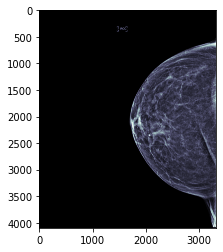

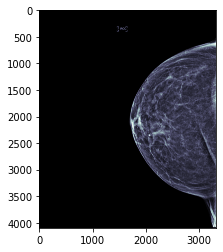

In [73]:
import cv2
ds = dcmread('../../data/train_images/25/822390278.dcm')


img = ds.pixel_array # dtype = uint16
img = img*ds.RescaleSlope + ds.RescaleIntercept    
# print(ds.pixel_array.shape)
# print(ds.file_meta.TransferSyntaxUID)
display_img = apply_ct_window(img, [img.shape[0],img.shape[1]])

img_bbox = Image.fromarray(ds.pixel_array.astype('float64'))
# img_bbox = img_bbox.convert('RGB')
# img_bbox.save('test')
img_arr = img_to_array(img_bbox)/255

img2 = np.zeros( ( np.array(ds.pixel_array).shape[0], np.array(ds.pixel_array).shape[1], 3 ) )
img2[:,:,0] = ds.pixel_array # same value in each channel
img2[:,:,1] = ds.pixel_array
img2[:,:,2] = ds.pixel_array

print(img2.shape)

# print(img_arr.shape)
plt.imshow(ds.pixel_array, cmap='bone')  # set the color map to bone
plt.show()


plt.imshow(img_arr, cmap='bone')  # set the color map to bone
plt.show()

In [44]:
model = tf.keras.applications.DenseNet201(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

model.fit(ds.pixel_array)

82524592/82524592 [==============================] - 2s 0us/step


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [35]:
ds.decompress("pylibjpeg")
ds.pixel_array.shape

(4096, 3328)

In [4]:
arr = ds.pixel_array
arr.shape

(2776, 2082)

In [2]:
target_path = '../../data/breast_imaging/cancer'

list_of_dirs = [x for x in os.listdir(target_path)]

sparse_dir_list = []
for dir_name in list_of_dirs[0:1]:
  path = f'{target_path}/{dir_name}'
  for dirs in os.listdir(path):
    sparse_dir_list.append(f'{path}/{dirs}')
    print(f'{path}/{dirs}')
sparse_dir_list

../../data/breast_imaging/cancer/10130/cancer_0.npz
../../data/breast_imaging/cancer/10130/cancer_1.npz
../../data/breast_imaging/cancer/10130/cancer_2.npz
../../data/breast_imaging/cancer/10130/cancer_3.npz


['../../data/breast_imaging/cancer/10130/cancer_0.npz',
 '../../data/breast_imaging/cancer/10130/cancer_1.npz',
 '../../data/breast_imaging/cancer/10130/cancer_2.npz',
 '../../data/breast_imaging/cancer/10130/cancer_3.npz']

In [3]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

# For reproducibility
np.random.seed(42)
from scipy import sparse


In [5]:

arr = []

for each_sparse_path in sparse_dir_list:
  sparse_matrix = sparse.load_npz(each_sparse_path)
  arr.append(sparse_matrix.todense())


np.array(arr).shape

(4, 1000, 1000)

In [47]:
y = [1] * 5 + [0] * 5
X_train, X_test, y_train, y_test = train_test_split(np.array(arr), np.array(y), random_state=42)


In [48]:
model = Sequential()

model.add(layers.Input(shape=(1000,1000, 1)))

# First Convolution
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Second Convolution
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten
model.add(Flatten())

# Fully Connected
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [49]:
h = model.fit(
    X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test)
)


Epoch 1/5
1/1 [==============================] - 24s 24s/step - loss: 0.6896 - accuracy: 0.4286 - val_loss: 2.8925e-18 - val_accuracy: 1.0000
Epoch 2/5
1/1 [==============================] - 17s 17s/step - loss: 5.9989 - accuracy: 0.8571 - val_loss: 10.4021 - val_accuracy: 0.3333
Epoch 3/5
1/1 [==============================] - 8s 8s/step - loss: 2.8828 - accuracy: 0.5714 - val_loss: 5.0323e-10 - val_accuracy: 1.0000
Epoch 4/5
1/1 [==============================] - 7s 7s/step - loss: 0.3044 - accuracy: 0.8571 - val_loss: 1.0756e-13 - val_accuracy: 1.0000
Epoch 5/5
1/1 [==============================] - 7s 7s/step - loss: 0.5021 - accuracy: 0.8571 - val_loss: 6.6828e-10 - val_accuracy: 1.0000


In [5]:
def load_images(imagePath):
	# read the image from disk, decode it, convert the data type to
	# floating point, and resize it
	image = tf.io.read_file(imagePath)
	image = dcmread(imagePath)
	image = tf.image.convert_image_dtype(image.pixel_array, dtype=tf.float32)
	IMG_PX_SIZE = 512
	
	image = resize(image, (IMG_PX_SIZE, IMG_PX_SIZE), anti_aliasing=True)
	# parse the class label from the file path
	label = tf.strings.split(imagePath, os.path.sep)[-2]
	
	# return the image and the label
	return (image, label)

In [6]:
data_augmentation = Sequential([
	layers.Rescaling(scale=1.0 / 255),
	layers.RandomFlip("horizontal_and_vertical"),
	layers.RandomZoom(
		height_factor=(-0.05, -0.15),
		width_factor=(-0.05, -0.15)),
	layers.RandomRotation(0.3),
])



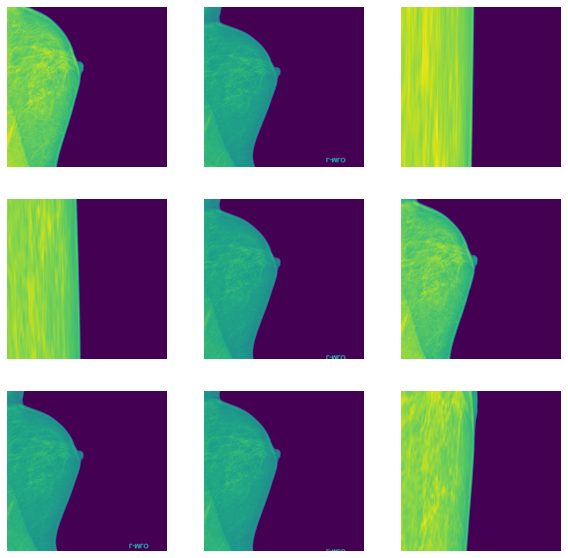

In [7]:

	
image = resize(arr, (IMG_PX_SIZE, IMG_PX_SIZE), anti_aliasing=True)
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [8]:
image.shape

TensorShape([1, 512, 512])

In [9]:


def visualize(original, augmented):
  plt.figure(figsize=(10, 10))
  for i in range(9):

    augmented_image = augmented(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")
  
image.shape

grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()


InvalidArgumentError: {{function_node __wrapped__MatMul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Matrix size-incompatible: In[0]: [512,512], In[1]: [3,1] [Op:MatMul]

In [ ]:
resized_img.shape

(512, 512)